In [47]:
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import tensorflow
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
import torch
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as v2
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from sklearn.metrics.pairwise import euclidean_distances
from PIL import Image,ImageFilter
import torchvision.transforms as transforms
import pickle
import os
os.system("gdown --id 1qO2OLR7skDibo1LaMKD3CiOl_jaCTZ0h")

In [ ]:
IMAGE_SIZE = 224
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
    
class HiddenLayer(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.premodel = pretrained_model
        self.new_layer = nn.Sequential(
                nn.Linear(1000, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 10)
                )

    def forward(self, x):
        out = self.premodel(x)
        out_new_layer = self.new_layer(out)
        return out_new_layer
    


def predict(features_path,image):
    batch1 = unpickle("Model\data\data_batch_1")
    batch2 = unpickle("Model\data\data_batch_1")
    batch3 = unpickle("Model\data\data_batch_1")
    batch4 = unpickle("Model\data\data_batch_1")
    batch5 = unpickle("Model\data\data_batch_1")
    test_batch = unpickle("Model\data\test_batch")
    train_batch = [batch1,batch2,batch3,batch4,batch5]
    train_y = []
    train_x = []
    for batch in train_batch:
      y_data = batch[b'labels']
      x_data = batch[b'data']
      x_data = x_data.reshape(len(x_data),3,32,32).transpose(0,2,3,1)

      for i in range(len(y_data)):
        train_y.append(y_data[i])

      for i in range(len(y_data)):
        train_x.append(x_data[i])
    
    features = torch.load(features_path)
    
    resnet_train_data = []
    for i in range(len(features)):
      resnet_train_data.append((features[i],train_y[i]))
                          
    class_images_dict = {}
    for batch_idx, (images, labels) in enumerate(resnet_train_data):
        if labels not in class_images_dict:
            class_images_dict[labels] = []
        class_images_dict[labels].append(batch_idx)
     
    transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    image_resized = image.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
    image_tensor = transform(image_resized).unsqueeze(0) 
    image_tensor = image_tensor.to(device)

    resnet = models.resnet50(pretrained=True)

    x = torch.randn((2, 3, 32, 32))

    print(x.shape)
    model_check = HiddenLayer(resnet)
    model_check.load_state_dict(torch.load("CIFAR_end_hll.pt"))
    model_check.eval()
    
    with torch.no_grad():
        z = model_check(image_tensor)
        _, test_label = torch.max(z, 1)
                          
    return test_label,z,features,class_images_dict,train_x
    
    

In [50]:
def retrieve(image,feature_path,k):

    test_label,z,features,class_images_dict,train_x = predict(feature_path,image)
    class_indices = class_images_dict[test_label.item()]
    class_features = [(features[idx], idx) for idx in class_indices]
    test_features = z.cpu().detach().numpy()
    distances = euclidean_distances(test_features, [f[0].cpu() for f in class_features])
    sorted_indices = np.argsort(distances.flatten())[:k]
    closest_indices = [class_features[idx][1] for idx in sorted_indices]

    sharpened_test_image = image.filter(ImageFilter.SHARPEN)

    fig, axes = plt.subplots(1, len(closest_indices) + 1, figsize=(5, 5))

    axes[0].imshow(sharpened_test_image)
    axes[0].set_title('Test Image')
    axes[0].axis('off')

    for i, idx in enumerate(closest_indices):
        closest_image = Image.fromarray(train_x[idx])
        sharpened_closest_image = closest_image.filter(ImageFilter.SHARPEN)
        axes[i+1].imshow(sharpened_closest_image)
        axes[i+1].set_title(f"Closest Image {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout() 
    plt.show()


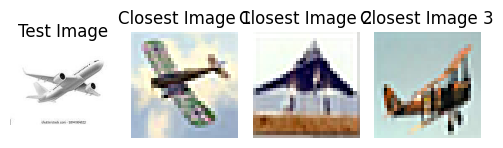

In [51]:
test_image = Image.open("/kaggle/input/planes/download.jpeg")
feature_path = "Model\Resnet50_train_features.pt"
retrieve(test_image,feature_path,3)